# Reddit Comment Removal - Dataset Exploration

In [1]:
import pandas as pd
import numpy as np
from nltk import word_tokenize

In [5]:
# dataset paths
train_set = "../data/reddit_train.csv"
test_set = "../data/reddit_test.csv"

In [39]:
def read_csv(file_path):
    return pd.read_csv(file_path,
                       encoding="ISO-8859-1")

# read the dataset
train_df = read_csv(train_set)
test_df = read_csv(test_set)

# print the header
train_df.head()


def clean_text(text, remove_stopwords=True, remove_punct=True, stem_words=False):
    """
    Clean the text, with the option to remove stopwords, remove punctuation and to stem words.
    The function is an adaptation from:
    https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text

    Args:
        text (str): text to clean
        remove_stopwords (bool, optional): Remove stop words
        remove_punct (bool, optional): Remove punctuation signs
        stem_words (bool, optional): Apply stemming

    Returns:
        str: clean string text based on the above cleaning options
    """
    import re
    import string
    from nltk.stem import SnowballStemmer
    
    if remove_punct:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        from nltk.corpus import stopwords
        stops = set(stopwords.words("english"))
        text = [w for w in text if w not in stops]
        
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)

    # Return a list of words
    return(text)

## Dataset balance as label counts

In [25]:
# Print a count of training labels
train_df['REMOVED'].value_counts()

0    14479
1     6857
Name: REMOVED, dtype: int64

In [26]:
# Print a count of test labels
test_df['REMOVED'].value_counts()

0    4812
1    2299
Name: REMOVED, dtype: int64

## Dataset input statistics

In [45]:
# Check the average length of the comments
train_lengths = train_df['BODY'].str.len()
print("Train comments:\n"
      "Mean length (in chars): {}\n"
      "Std length (in chars): {}".format(np.mean(train_lengths), np.std(train_lengths)))

# Length and std in tokens
train_tok = [word_tokenize(clean_text(x)) for x in train_df['BODY']]
train_tok_lens = [len(x) for x in train_tok]
print("Train comments:\n"
      "Mean length (in tokens): {}\n"
      "Std length (in tokens): {}".format(np.mean(train_tok_lens), np.std(train_tok_lens)))

Train comments:
Mean length (in chars): 321.2806524184477
Std length (in chars): 472.7121822509636
Train comments:
Mean length (in tokens): 56.79832208473941
Std length (in tokens): 80.98876080442994


In [46]:
# Check the average length of the test comments
test_lengths = test_df['BODY'].str.len()
print("Test comments:\n"
      "Mean length (in chars): {}\n"
      "Std length (in chars): {}".format(np.mean(test_lengths), np.std(test_lengths)))

# Length and std in tokens
test_tok = [word_tokenize(clean_text(x)) for x in test_df['BODY']]
test_tok_lens = [len(x) for x in test_tok]
print("Test comments:\n"
      "Mean length (in tokens): {}\n"
      "Std length (in tokens): {}".format(np.mean(test_tok_lens), np.std(test_tok_lens)))

Test comments:
Mean length (in chars): 323.56236816200254
Std length (in chars): 497.4754941306585
Test comments:
Mean length (in tokens): 57.11334552102377
Std length (in tokens): 85.04596079170932


## Voacbulary differences between removed vs non-removed

In [78]:
# get indices of removed comments
removed_idx = train_df.index[train_df['REMOVED'] ==  1]

# get indices of non-removed comments
kept_idx = train_df.index[train_df['REMOVED'] ==  0]

In [65]:
# Create a vocab object of removed comments and non removed comments
from collections import Counter
from pprint import pformat


# flatten the train tokens list of those comments that were removed
tokens_removed_comms = [train_tok[i] for i in removed_idx]
flat_removed_toks = [tok 
                   for tok_list in tokens_removed_comms 
                   for tok in tok_list]
removed_vocab = Counter(flat_removed_toks)


# flatten the train tokens list of those comments that were removed
tokens_kept_comms = [train_tok[i] for i in kept_idx]
flat_kept_toks = [tok 
                  for tok_list in tokens_kept_comms 
                  for tok in tok_list]
kept_vocab = Counter(flat_kept_toks)

# Check vocabulary that appears to be unique to removed comments
vocab_only_in_removed = removed_vocab - kept_vocab
print([
    v[0] 
    for v in vocab_only_in_removed.most_common(100)
])

['<', 'fuck', 'shit', 'weed', 'thumbnail', 'removed', 'kid', 'god', 'shrooms', 'mushrooms', 'dried', 'ah', 'blah', 'damn', 'mods', 'sulfate', 'atheists', 'dad', 'deleted', 'nsfw', 'censorship', 'proteinate', 'pizza', 'tits', 'atheist', 'huh', 'hillary', 'threads', 'fermentation', 'alex', 'ruin', 'fury', 'turkey', 'fe0f', 'chocolate', 'shouting', 'pepto', 'lamb', 'earplugs', 'cigar', 'lbs', 'sit', 'wtf', 'tyson', 'graveyard', 'crying', 'leptin', 'groog', 'lactobacillus', 'shocking', 'ship', 'trip', 'ruined', 'introvert', 'yup', 'cheese', 'motives', 'laying', 'bye', 'ha', 'lied', 'hears', 'whiskey', 'spaceship', 'twenties', 'tocopherols', 'peat', 'intermittent', 'asshole', 'nerds', 'herself', 'condescending', 'legalize', 'usda', 'coke', 'ocd', 'doom', 'attitude', 'chicken', 'stoners', 'guessed', 'naps', 'lock', 'bigoted', 'horny', 'shits', 'sophomore', 'vindication', 'moron', 'antifa', 'walks', 'tripping', 'woken', 'morty', 'censored', 'freeze', 'highschool', 'iamverysmart', 'surf', 'doo

# Sentiment, Toxicity and Formality of removed vs non-removed

In [62]:
# We extract sentiment, toxicity, formality and subjectivity measures
# for a sample of removed and non-removed comments

def sent_analysis(text):
    import requests
    import json
    
    # This function uses a private URL for sentiment analysis and therefore
    # has been removed from the notebook
    sentiment_analysis_url = "https://sentiment-analysis.xxxxxxxxxxxx"
    
    try:
        payload = json.dumps({"sentence": text})
        headers = {'Content-Type': "application/json"}
        response = requests.request("POST", sentiment_analysis_url, 
                                    data=payload, headers=headers)
        return response.json()
    except Exception as e:
        print("Error while retrieving sentiment analysis: {}".format(e))


### Analyse a sample of removed and non-removed comments

In [86]:
# Get sentiment analysis for a sample of removed comments
removed_sentiments = []
for i, idx in enumerate(np.random.choice(removed_idx, 50)):
    text = train_df['BODY'].iloc[idx]
    assert train_df['REMOVED'].iloc[idx] == 1
    sent = sent_analysis(text)
    removed_sentiments.append(sent)
    if i < 5:
        print("{} --> {}\n".format(text, sent))


As a night owl I found the best semesters for me at college were when I scheduled 5pm classes. Each course was once a week for 4 hours. It didn't always work out thay way, but it did help with my attentiveness in class. Seven am classes not so much.  --> {'formality': 0.5661232546998023, 'toxicity': 0.017576318900113075, 'subjectivity': 0.25, 'sentiment': 0.49873669154476374}

I personally would like to congratulate science on researching literally every other topic on the planet, as I'd imagine that's the only way we ended up researching ambidextrous elk.  --> {'formality': 0.6698249557942255, 'toxicity': 0.2455305297017582, 'subjectivity': 0.5583333333333333, 'sentiment': 0.5395335368812084}

china does good = btc goes up

china does bad = btc goes up a lot

very risky investment, be scared  --> {'formality': 0.1763653420066535, 'toxicity': 0.8791208687893299, 'subjectivity': 0.5222222222222223, 'sentiment': 0.4222964942455292}

Cue the arguments about the meaning of "ad hominem." --

In [87]:
# Get sentiment analysis for a sample of non-removed comments
kept_sentiments = []
for i, idx in enumerate(np.random.choice(kept_idx, 50)):
    text = train_df['BODY'].iloc[idx]
    assert train_df['REMOVED'].iloc[idx] == 0
    sent = sent_analysis(text)
    kept_sentiments.append(sent)
    if i < 5:
        print("{} --> {}\n".format(text, sent))

It is my understanding of Alzheimer's is that it has a strong environmental component. Especially diet seems to play a role with some research even going so far as calling the disease preventable on a plant based diet. This is supported by age corrected epidemiology of groups in the Third World and groups on non-standard diets in the developed world. My question then:

This genetic predictor of age of onset, is it or could it be linked to additional environmental predictors to come to a complete picture? And if not, how useful is this predictor for groups who eat healthier than standard diets such as vegetarians, those on plant based diets (upwards of 95% plant based) and vegans? --> {'formality': 0.8402130972245848, 'toxicity': 0.07024986012418574, 'subjectivity': 0.437037037037037, 'sentiment': 0.4514645226299763}

One of the bottlenecks of high-temperature superconductivity has been the fact that we don't understand, even now, what's really gluing the electrons into pairs. --> {'for

### Plot average and variance of each measure

In [90]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_bars(means, stds, xlabels):
    N = len(means)                  # how many bars per measure
    ind = np.arange(len(means[0]))  # the x locations for the groups
    width = 0.35                    # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width/2, means[0], width, yerr=stds[0],
                    label='Removed')
    rects2 = ax.bar(ind + width/2, means[1], width, yerr=stds[1],
                    label='Non-removed')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Scores by class (removed vs non-removed)')
    ax.set_xticks(ind)
    ax.set_xticklabels(xlabels)
    ax.legend()

<IPython.core.display.Javascript object>


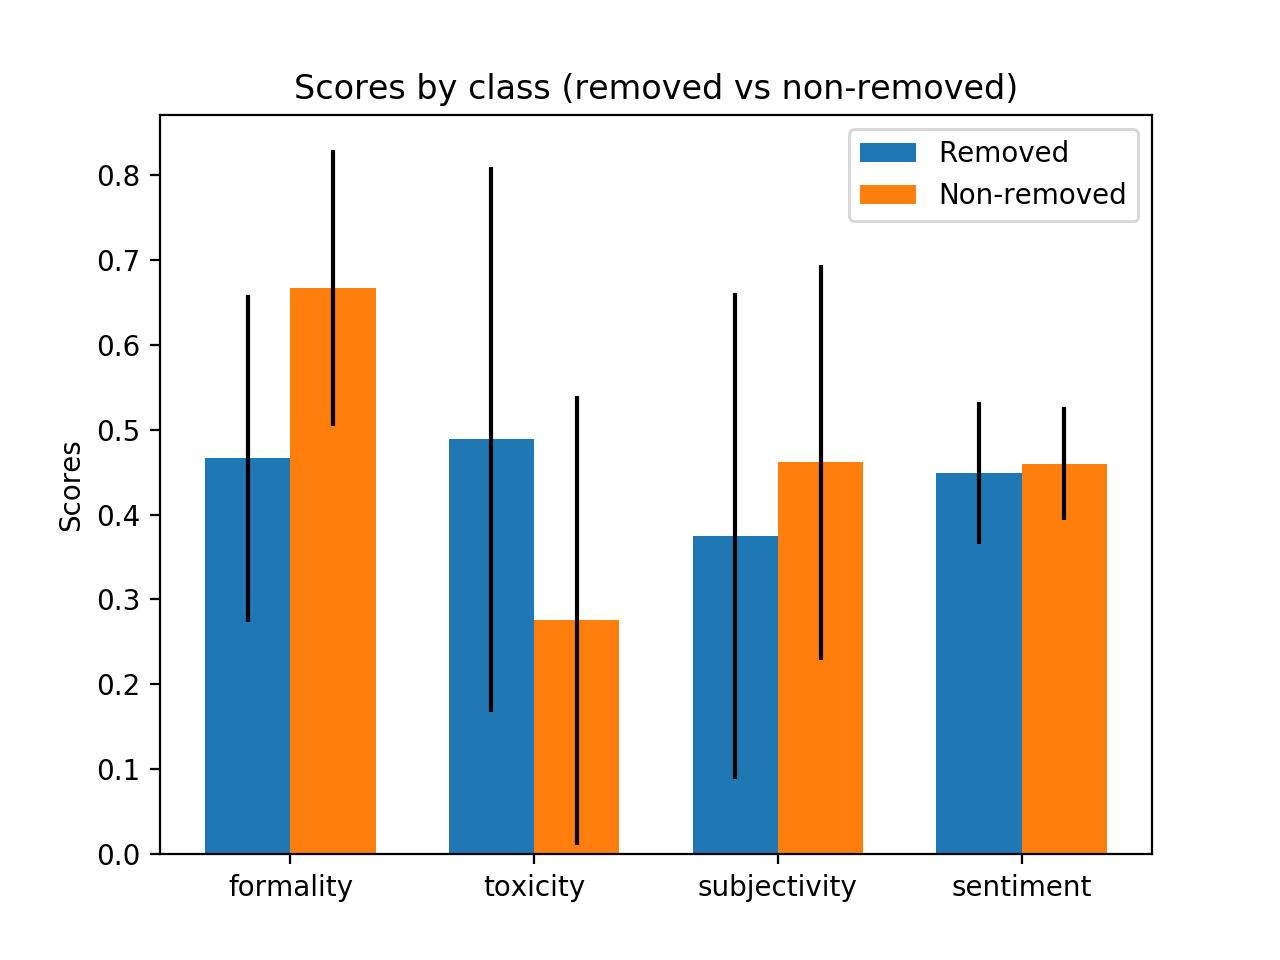

In [91]:
xlabels = ['formality', 'toxicity', 'subjectivity', 'sentiment']

means = np.zeros((2, len(xlabels)))
stds = np.zeros((2, len(xlabels)))

# calculate the mean and std of each sample in the removed set
for i, lbl in enumerate(xlabels):
    vals = [s.get(lbl) for s in removed_sentiments]
    means[0][i] = np.mean(vals)
    stds[0][i] = np.std(vals)

# calculate the mean and std of each sample in the non-removed set
for i, lbl in enumerate(xlabels):
    vals = [s.get(lbl) for s in kept_sentiments]
    means[1][i] = np.mean(vals)
    stds[1][i] = np.std(vals)

plot_bars(means, stds, xlabels)